# Using NZRA Data as Targets

We have refined the AI task to better reflect how the model will be used at inference time. The task is as follows:

#### Context Sets
1. Gridded context: ERA5, Himawari 8, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. Points from NZRA, sampled at random locations.
2. (tbc) held-out station observations.

This is the first experiment which we are developing & running on the NIWA HPC.

## Experiment Setup
- do imports
- set up project wide settings & variables

In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# setup logging
from convcnp_assim_nz.config.logging_config import setup_logging
import logging

setup_logging()  # configure logging
logger = logging.getLogger(__name__)
logger.info("Notebook execution started.")

2026-01-12 22:12:49 - INFO - __main__ - Notebook execution started.


In [9]:
# setup tensorboard

import os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

TB_BASE = "/home/crowelenn/dev/convcnp-assim-nz"
TB_EXPERIMENT = "experiment4"
TB_PREFIX = "debug_runs"

# tensorboard tags
TB_TRAIN_LOSS = "Loss/Train"
TB_VAL_LOSS = "Loss/Validation"
TB_RUN_LOGS = "Run/Steps"
TB_EXAMPLE_TASK = "Tasks/Example"
TB_CUDA_MEM = "System/CUDA_Memory_MB"

tb_path = os.path.join(TB_BASE, ".tensorboard", TB_EXPERIMENT, TB_PREFIX, f"run_{datetime.now().strftime('%d-%m-%YT%H:%M:%S')}")

tb_writer = SummaryWriter(log_dir=tb_path)

In [10]:
# imports from this repo
%autoreload 2
from convcnp_assim_nz.config.env_loader import use_absolute_filepaths, get_env_var
from convcnp_assim_nz.utils.variables.var_names import *
from convcnp_assim_nz.utils.variables.coord_names import *
from convcnp_assim_nz.data_processing.nzra_processor import ProcessNZRA
from convcnp_assim_nz.data_processing.topography_processor import ProcessTopography
from convcnp_assim_nz.data_processing.himawari8_processor import ProcessHimawari8
from convcnp_assim_nz.data_processing.era5_processor import ProcessERA5
from convcnp_assim_nz.data_processing.station_processor import ProcessStations
from convcnp_assim_nz.data_processing.conversions.scalar_conversions import kelvin_to_celsius
from convcnp_assim_nz.data_processing.auxiliary.sun_position import get_sun_culmination, get_sun_position

In [11]:
# imports from external libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from deepsensor.train.train import set_gpu_default_device
import deepsensor.torch
import torch
from mpl_toolkits.basemap import Basemap
import os

In [12]:
logger.info(f"CUDA available: {torch.cuda.is_available()}")

2026-01-12 22:12:49 - INFO - __main__ - CUDA available: False


In [ ]:
# variables for this experiment
dev = os.getenv("DEVELOPMENT_ENVIRONMENT", "1")
dataset_generation = os.getenv("DATASET_GENERATION", "0")

dev = True if dev == "1" else False
dataset_generation = True if dataset_generation == "1" else False

years = [2017]
target_variable = TEMPERATURE

if not os.environ["HOSTNAME"] == 'hub-worker01': # no GPU available on jupyter node
    set_gpu_default_device()

use_absolute_filepaths(True)


In [ ]:
tb_writer.add_text(TB_RUN_LOGS, f'Experiment 4 started {"in dataset generation mode" if dataset_generation else "without dataset generation"} {"in development mode." if dev else "in production mode."}', 0)
tb_writer.flush()

## Preprocess the datasets

In [ ]:
if dataset_generation:
    logger.info("Data Preprocessing started. This notebook will run in dataset generation mode.")
else:
    logger.info("Data Preprocessing started. This notebook will not generate a dataset, and will load data from existing files.")

if dev:
    logger.warning("Running in development mode with reduced dataset sizes and increased coarsening.")

2026-01-12 22:12:49 - INFO - __main__ - Data Preprocessing started. This notebook will not generate a dataset, and will load data from existing files.
2026-01-12 22:12:49 - WARNING - __main__ - Running in development mode with reduced dataset sizes and increased coarsening.


In [16]:
topography_processor = ProcessTopography()
nzra_processor = ProcessNZRA()
era5_processor = ProcessERA5()
h8_processor = ProcessHimawari8()
station_processor = ProcessStations(mode="csv")

In [17]:
# load datasets
topography_ds = topography_processor.load_ds()
nzra_ds = nzra_processor.load_ds(years=years)
h8_ds = h8_processor.load_ds(years=years)
era5_ds = era5_processor.load_ds(years=years)
stations_df = station_processor.load_df([TEMPERATURE], csv_file='esnz-observations_temp_20170101-20171231.csv', year_start=2017, year_end=2017)

2026-01-12 22:12:51 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-12 22:12:52 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json
2026-01-12 22:12:52 - INFO - fsspec.reference - Read reference from URL /esi/project/niwa00004/riom/data/nzra/nzra_20130101-20181231.json


Loaded CSV with length 2153680
Loaded CSV with length 2148123


In [ ]:
# make small subsets for the dev environment
if dev:
    # filter all datasets to the first 24*7 time steps (7 days)
    nzra_ds = nzra_ds.isel(time=slice(0, 24*7))
    h8_ds   = h8_ds.isel(time=slice(0, 24*7))
    era5_ds = era5_ds.isel(time=slice(0, 24*7))
    stations_df = stations_df[(stations_df['time'] > nzra_ds['time'].values.min()) & (stations_df['time'] < nzra_ds['time'].values.max())]

    # set topography coarsening factor
    TOPO_COARSEN = 5
    H8_COARSEN = 5
else:
    TOPO_COARSEN = 2
    H8_COARSEN = 2

In [19]:
# preprocess the stations
stations_df = stations_df[[TEMPERATURE, LATITUDE, LONGITUDE, TIME]]

stations_reset = stations_df.reset_index()
stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE]).resample("1h", on=TIME).mean()[[TEMPERATURE]]
stations_resample = stations_resample.reset_index().set_index([TIME, LATITUDE, LONGITUDE]).sort_index()

# crop the stations to NZ bounds
crop_bottom = nzra_ds.lat.min().item()
crop_top = nzra_ds.lat.max().item()
crop_left = nzra_ds.lon.min().item()
crop_right = nzra_ds.lon.max().item()

stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

/var/tmp/pbs.1577430.pbsserver01/ipykernel_1122699/2623791328.py:5: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby([LATITUDE, LONGITUDE]).resample("1h", on=TIME).mean()[[TEMPERATURE]]


In [20]:
# preprocess NZRA
if TEMPERATURE in nzra_ds.data_vars:
    nzra_ds[TEMPERATURE] = kelvin_to_celsius(nzra_ds[TEMPERATURE])

nzra_ds = nzra_ds[[target_variable]]

In [21]:
# preprocess H8
h8_ds = h8_ds.resample(time="1h").nearest(tolerance="30min")

h8_ds = h8_ds[[BAND_3, BAND_9, BAND_13]]

h8_ds = h8_ds.coarsen(lat=H8_COARSEN, lon=H8_COARSEN, boundary="trim").mean()

In [22]:
# preprocess ERA5
era5_ds = era5_ds.isel(level=-1) # select nearest to surface level (geopotential == 1000) only

# convert temperature from K to C
if TEMPERATURE in era5_ds.data_vars:
    era5_ds[TEMPERATURE] = kelvin_to_celsius(era5_ds[TEMPERATURE])

# add sun angle and culmination to ERA5 dataset
era5_ds[SUN_CULMINATION] = get_sun_culmination(era5_ds.coords)
era5_ds[SUN_ANGLE] = get_sun_position(era5_ds.coords)

In [23]:
# preprocess auxiliary dataset (topography, tpi, land/sea mask)
ds_aux = topography_processor.compute_tpi(topography_ds, window_sizes=[0.1])
ds_aux = ds_aux.reindex({LATITUDE: nzra_ds[LATITUDE], LONGITUDE: nzra_ds[LONGITUDE]}, method='nearest') # expand to the NZRA grid

ds_aux[LAND_SEA_MASK] = ds_aux[ELEVATION].where(ds_aux[ELEVATION].isnull(), 1, 0).fillna(0)

ds_aux_coarse  = ds_aux.coarsen(
    lat=TOPO_COARSEN, 
    lon=TOPO_COARSEN, 
    boundary='trim').mean()

ds_aux = ds_aux.fillna(0)
ds_aux_coarse = ds_aux_coarse.fillna(0)

In [24]:
# crop all datasets to a square bound of lat -32.5, -47.5 and lon 165, 180
crop_bottom = -47.5
crop_top = -32.5
crop_left = 165.0
crop_right = 180.0

nzra_ds = nzra_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
era5_ds = era5_ds.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))
h8_ds = h8_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
ds_aux = ds_aux.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))
ds_aux_coarse = ds_aux_coarse.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))

stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]

In [25]:
logger.info("Dataset preprocessing completed.")
tb_writer.add_text(TB_RUN_LOGS, "Dataset preprocessing completed.", 1)
tb_writer.flush()

2026-01-12 22:13:49 - INFO - __main__ - Dataset preprocessing completed.


## Visualise data sources

#### Himawari 8

Visualise the himawari8 dataset in bands 3, 9, and 13. Each band provides different information about clouds in the atmosphere.

This will be assimilated into the ERA5 data

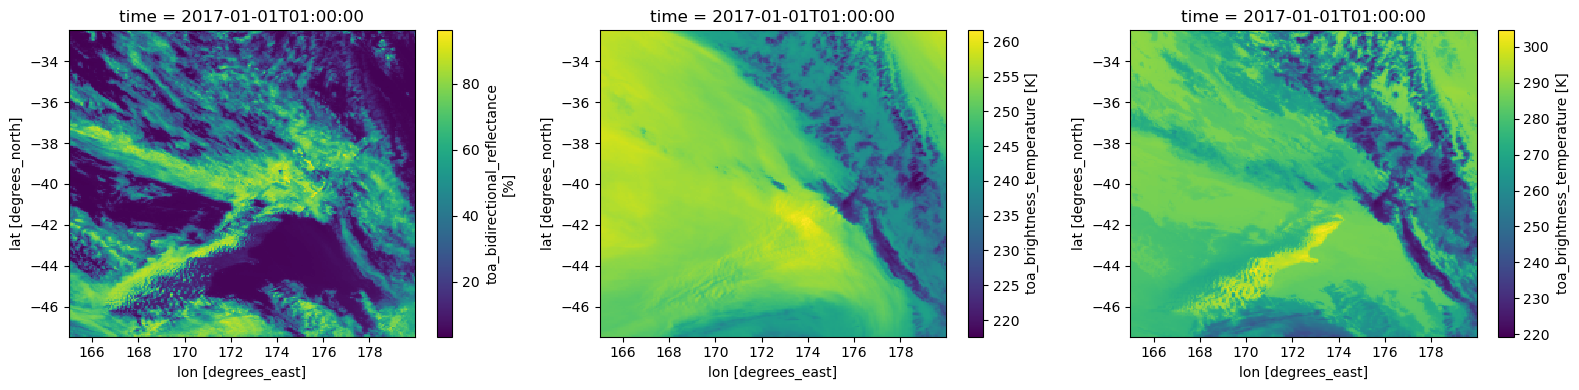

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
h8_ds.isel(time=1)[BAND_3].plot(ax=ax[0])
h8_ds.isel(time=1)[BAND_9].plot(ax=ax[1])
h8_ds.isel(time=1)[BAND_13].plot(ax=ax[2])

plt.tight_layout()

#### NZRA
Visualise temperature from the NZRA dataset.

This will be sampled from and used as the target set.

For initial experiments, the target is 'temperature' but will be updated as use-cases require.

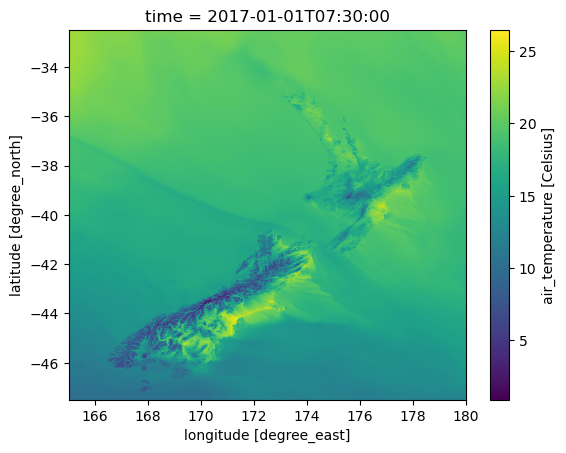

In [27]:
nzra_ds[target_variable].isel(time=9).plot()

#### Auxiliary
Elevation, TPI, and land/sea mask.

This is auxiliary - i.e. constant across time.

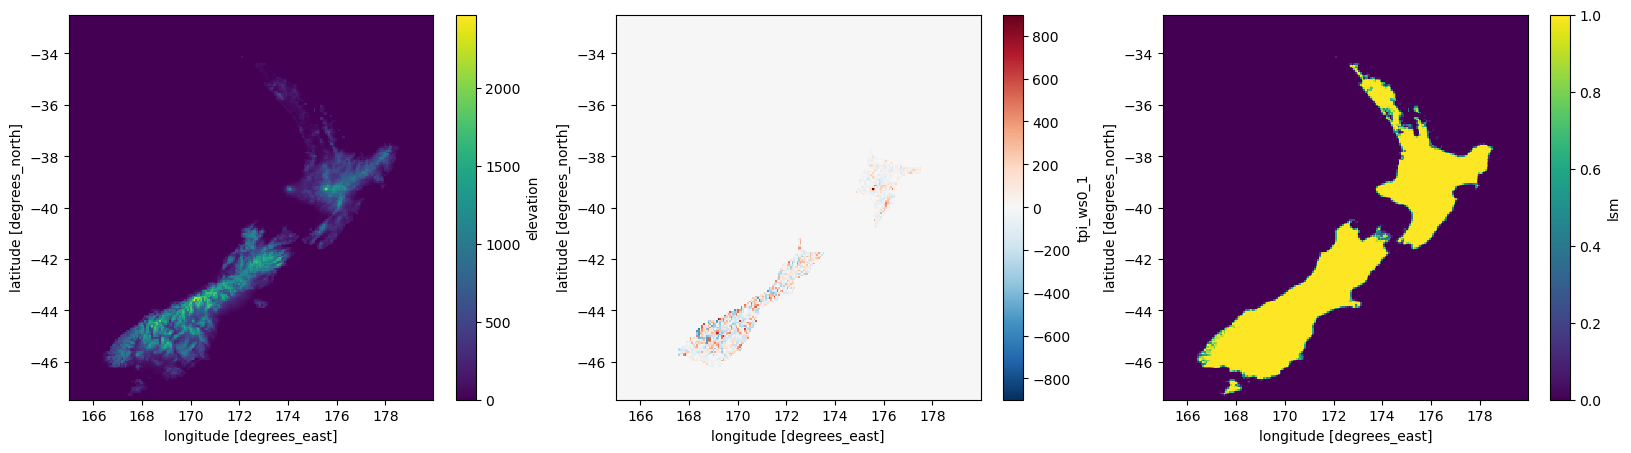

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ds_aux_coarse[ELEVATION].plot(ax=ax[0])
ds_aux_coarse[f"{TOPOGRAPHIC_POSITION_INDEX}_ws0_1"].plot(ax=ax[1])
ds_aux_coarse[LAND_SEA_MASK].plot(ax=ax[2])

#### ERA5
The following six variables together form a closed description of the atmosphere. We may include all these variables in the model.

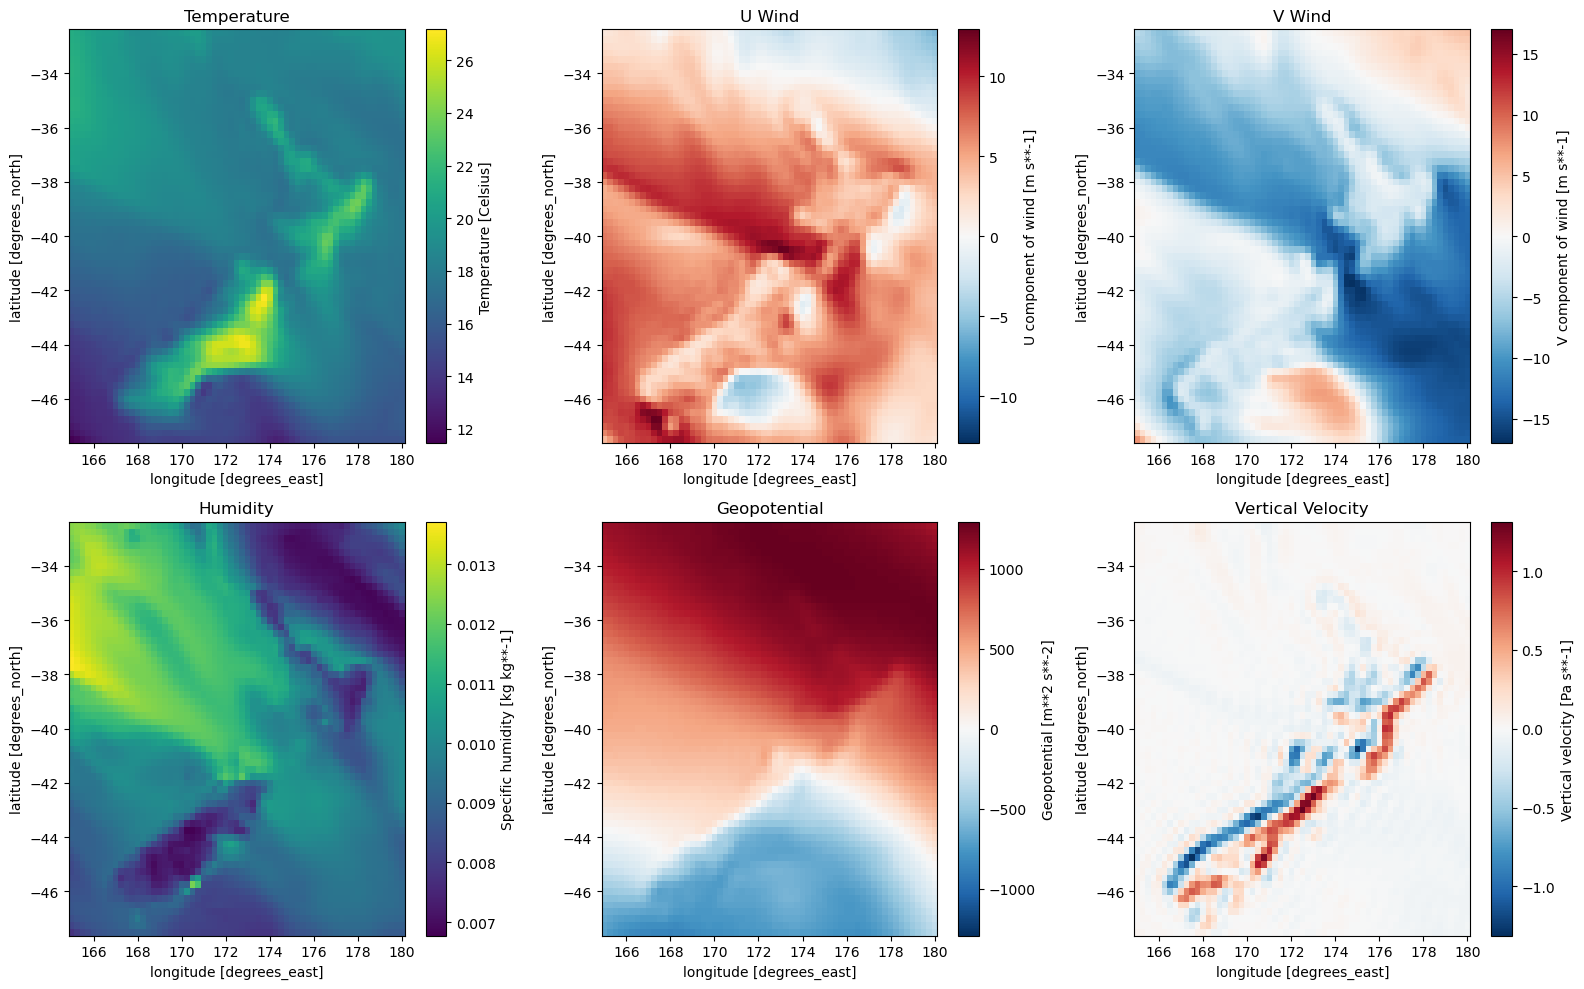

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

era5_ds[TEMPERATURE].isel(time=0).plot(ax=ax[0, 0])
ax[0, 0].set_title("Temperature")

era5_ds[WIND_U].isel(time=0).plot(ax=ax[0, 1])
ax[0, 1].set_title("U Wind")

era5_ds[WIND_V].isel(time=0).plot(ax=ax[0, 2])
ax[0, 2].set_title("V Wind")

era5_ds[HUMIDITY].isel(time=0).plot(ax=ax[1, 0])
ax[1, 0].set_title("Humidity")

era5_ds[GEOPOTENTIAL].isel(time=0).plot(ax=ax[1, 1])
ax[1, 1].set_title("Geopotential")

era5_ds[VERTICAL_VELOCITY].isel(time=0).plot(ax=ax[1, 2])
ax[1, 2].set_title("Vertical Velocity")
plt.tight_layout()

#### ERA5 Sun Position Annotations

The sun culmination and sun angle have been added as extra channels to ERA5 to encode time of year and time of day respectively.

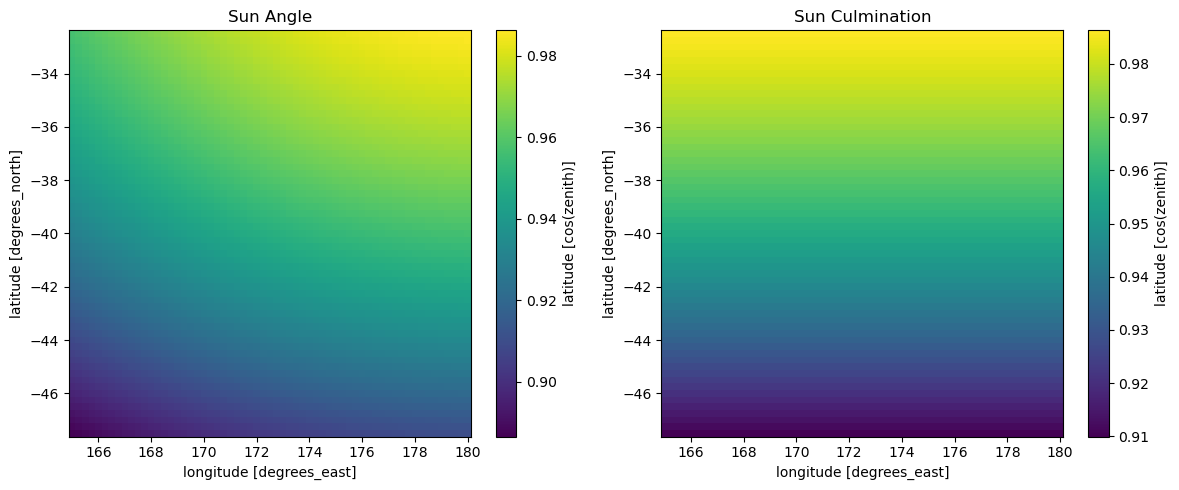

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

era5_ds[SUN_ANGLE].isel(time=0).plot(ax=ax[0])
ax[0].set_title("Sun Angle")

era5_ds[SUN_CULMINATION].isel(time=0).plot(ax=ax[1])
ax[1].set_title("Sun Culmination")

plt.tight_layout()

#### Ground Stations

A subset (and arbitrary number) of ground stations will be used as off-grid inputs to the model.

A set of stations can also be used as supplementary target points to NZRA - letting the model learn at spaces off the NZRA grid, and theoretically allowing the model to learn outputs which could be "more correct" than NZRA - provided the stations haven't been assimilated into NZRA.

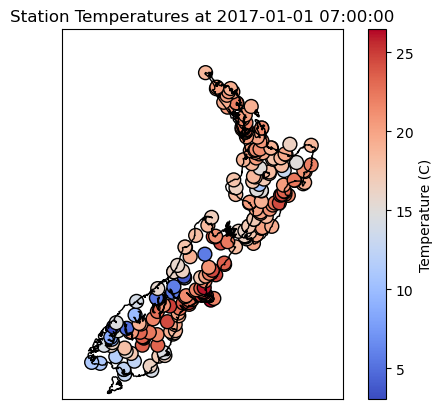

In [31]:
time_step = "2017-01-01 07:00:00"
m = Basemap(projection='merc', llcrnrlat=nzra_ds[LATITUDE].min().item(), urcrnrlat=nzra_ds[LATITUDE].max().item(), llcrnrlon=nzra_ds[LONGITUDE].min().item(), urcrnrlon=nzra_ds[LONGITUDE].max().item(), resolution='i')
m.drawcoastlines()
m.drawcountries()
x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
           stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
sc = m.scatter(x, y,
               c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['temperature'].values,
               cmap='coolwarm', marker='o', edgecolor='k', s=100)
plt.colorbar(sc, label='Temperature (C)')
plt.title(f'Station Temperatures at {time_step}')
plt.show()

## Deepsensor Dataset Generation

The data needs to be converted from xarray datasets/csv's into deepsensor tasks.

To reiterate the dataset structure:

#### Context Sets
1. Gridded context: ERA5, Himawari 8, sun position.
2. Offgrid context: Ground station observations.
3. Auxiliary: Topography, x1x2 encoding, land/sea mask.

#### Target Sets:
1. Points from NZRA, sampled at random locations.
2. (tbc) held-out station observations.

In [32]:
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device, concat_tasks
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.data.utils import construct_x1x2_ds

In [33]:
logger.info(f"Deepsensor task construction started: {h8_ds[LATITUDE].min()} to {h8_ds[LATITUDE].max()} for x1_map.")

2026-01-12 22:13:54 - INFO - __main__ - Deepsensor task construction started: <xarray.DataArray 'lat' ()> Size: 8B
array(-47.43799973)
Attributes:
    units:    degrees_north to <xarray.DataArray 'lat' ()> Size: 8B
array(-32.52050018)
Attributes:
    units:    degrees_north for x1_map.


In [50]:
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_ds[LATITUDE].min(), era5_ds[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_ds[LONGITUDE].min(), era5_ds[LONGITUDE].max()))

In [51]:
era5_processed, stations_processed, h8_processed, nzra_processed = data_processor([era5_ds, stations_resample, h8_ds, nzra_ds])
ds_aux_processed, ds_aux_coarse_processed = data_processor([ds_aux, ds_aux_coarse], method='min_max')

x1x2_ds = construct_x1x2_ds(ds_aux_coarse_processed)
ds_aux_coarse_processed['x1_arr'] = x1x2_ds['x1_arr']
ds_aux_coarse_processed['x2_arr'] = x1x2_ds['x2_arr']

In [58]:
task_loader = TaskLoader(
        context = [h8_processed, stations_processed, era5_processed, ds_aux_coarse_processed], 
        target = nzra_processed,
        aux_at_targets = ds_aux_processed)

model = ConvNP(data_processor, task_loader, unet_channels=(64,)*5, likelihood="gnp", internal_density=400)

dim_yc inferred from TaskLoader: (3, 1, 8, 5)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 3
Setting aux_t_mlp_layers: (64, 64, 64)
encoder_scales inferred from TaskLoader: [np.float32(0.0022624433), 0.00125, np.float32(0.00837942), np.float32(0.0022624435)]
decoder_scale inferred from TaskLoader: 0.0025


In [72]:
# set the number of samples within the NZRA grid to use as target points
target_sampling_count = 1000

if dev:
    repeat_sampling = 10
else:
    nzra_res = len(nzra_ds.isel(time=0)[LATITUDE]) * len(nzra_ds.isel(time=0)[LONGITUDE])
    repeat_sampling = (nzra_res // target_sampling_count) // 2

In [60]:
date_vals = np.unique(stations_processed.index.get_level_values('time').values)

train_pct = int(len(date_vals) * 0.8)
valid_pct = len(date_vals) - train_pct

train_first, train_last = date_vals[0], date_vals[train_pct - 1]
valid_first, valid_last = date_vals[train_pct], date_vals[-1]
task_loader.load_dask()

train_datetimes = era5_ds.sel(time=slice(train_first, train_last)).time.values
val_datetimes = era5_ds.sel(time=slice(valid_first, valid_last)).time.values

In [61]:
import pickle

dataset_pickle_path = get_env_var('DATASET_PICKLE_PATH')
models_path = get_env_var('MODEL_DIR')

train_suffix = 'experiment4_nzra_target_train_tasks'
val_suffix = 'experiment4_nzra_target_val_tasks'

train_dir = os.path.join(dataset_pickle_path, train_suffix)
val_dir = os.path.join(dataset_pickle_path, val_suffix)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [ ]:
# you can disable dataset generation by setting the DATASET_GENERATION env var to "0"
if dataset_generation:
    logger.info("Generating and saving Deepsensor tasks to disk.")

    for i, date in enumerate(train_datetimes):
        for j in range(repeat_sampling):
            train_path = os.path.join(train_dir, f"{i}_{j}.pkl")
            task = task_loader(date, context_sampling=["all", "all", "all", "all"], target_sampling=[target_sampling_count])
            
            with open(train_path, 'wb') as f:
                pickle.dump(task, f)

    for i, date in enumerate(val_datetimes):
        for j in range(repeat_sampling):
            val_path = os.path.join(val_dir, f"{i}_{j}.pkl")
            task = task_loader(date, context_sampling=["all", "all", "all", "all"], target_sampling=[target_sampling_count])
            
            with open(val_path, 'wb') as f:
                pickle.dump(task, f)

    logger.info("Deepsensor task dataset generation completed.")
    tb_writer.add_text(TB_RUN_LOGS, "Deepsensor task dataset generation completed.", 2)
else:
    tb_writer.add_text(TB_RUN_LOGS, "Deepsensor task dataset generation skipped.", 2)

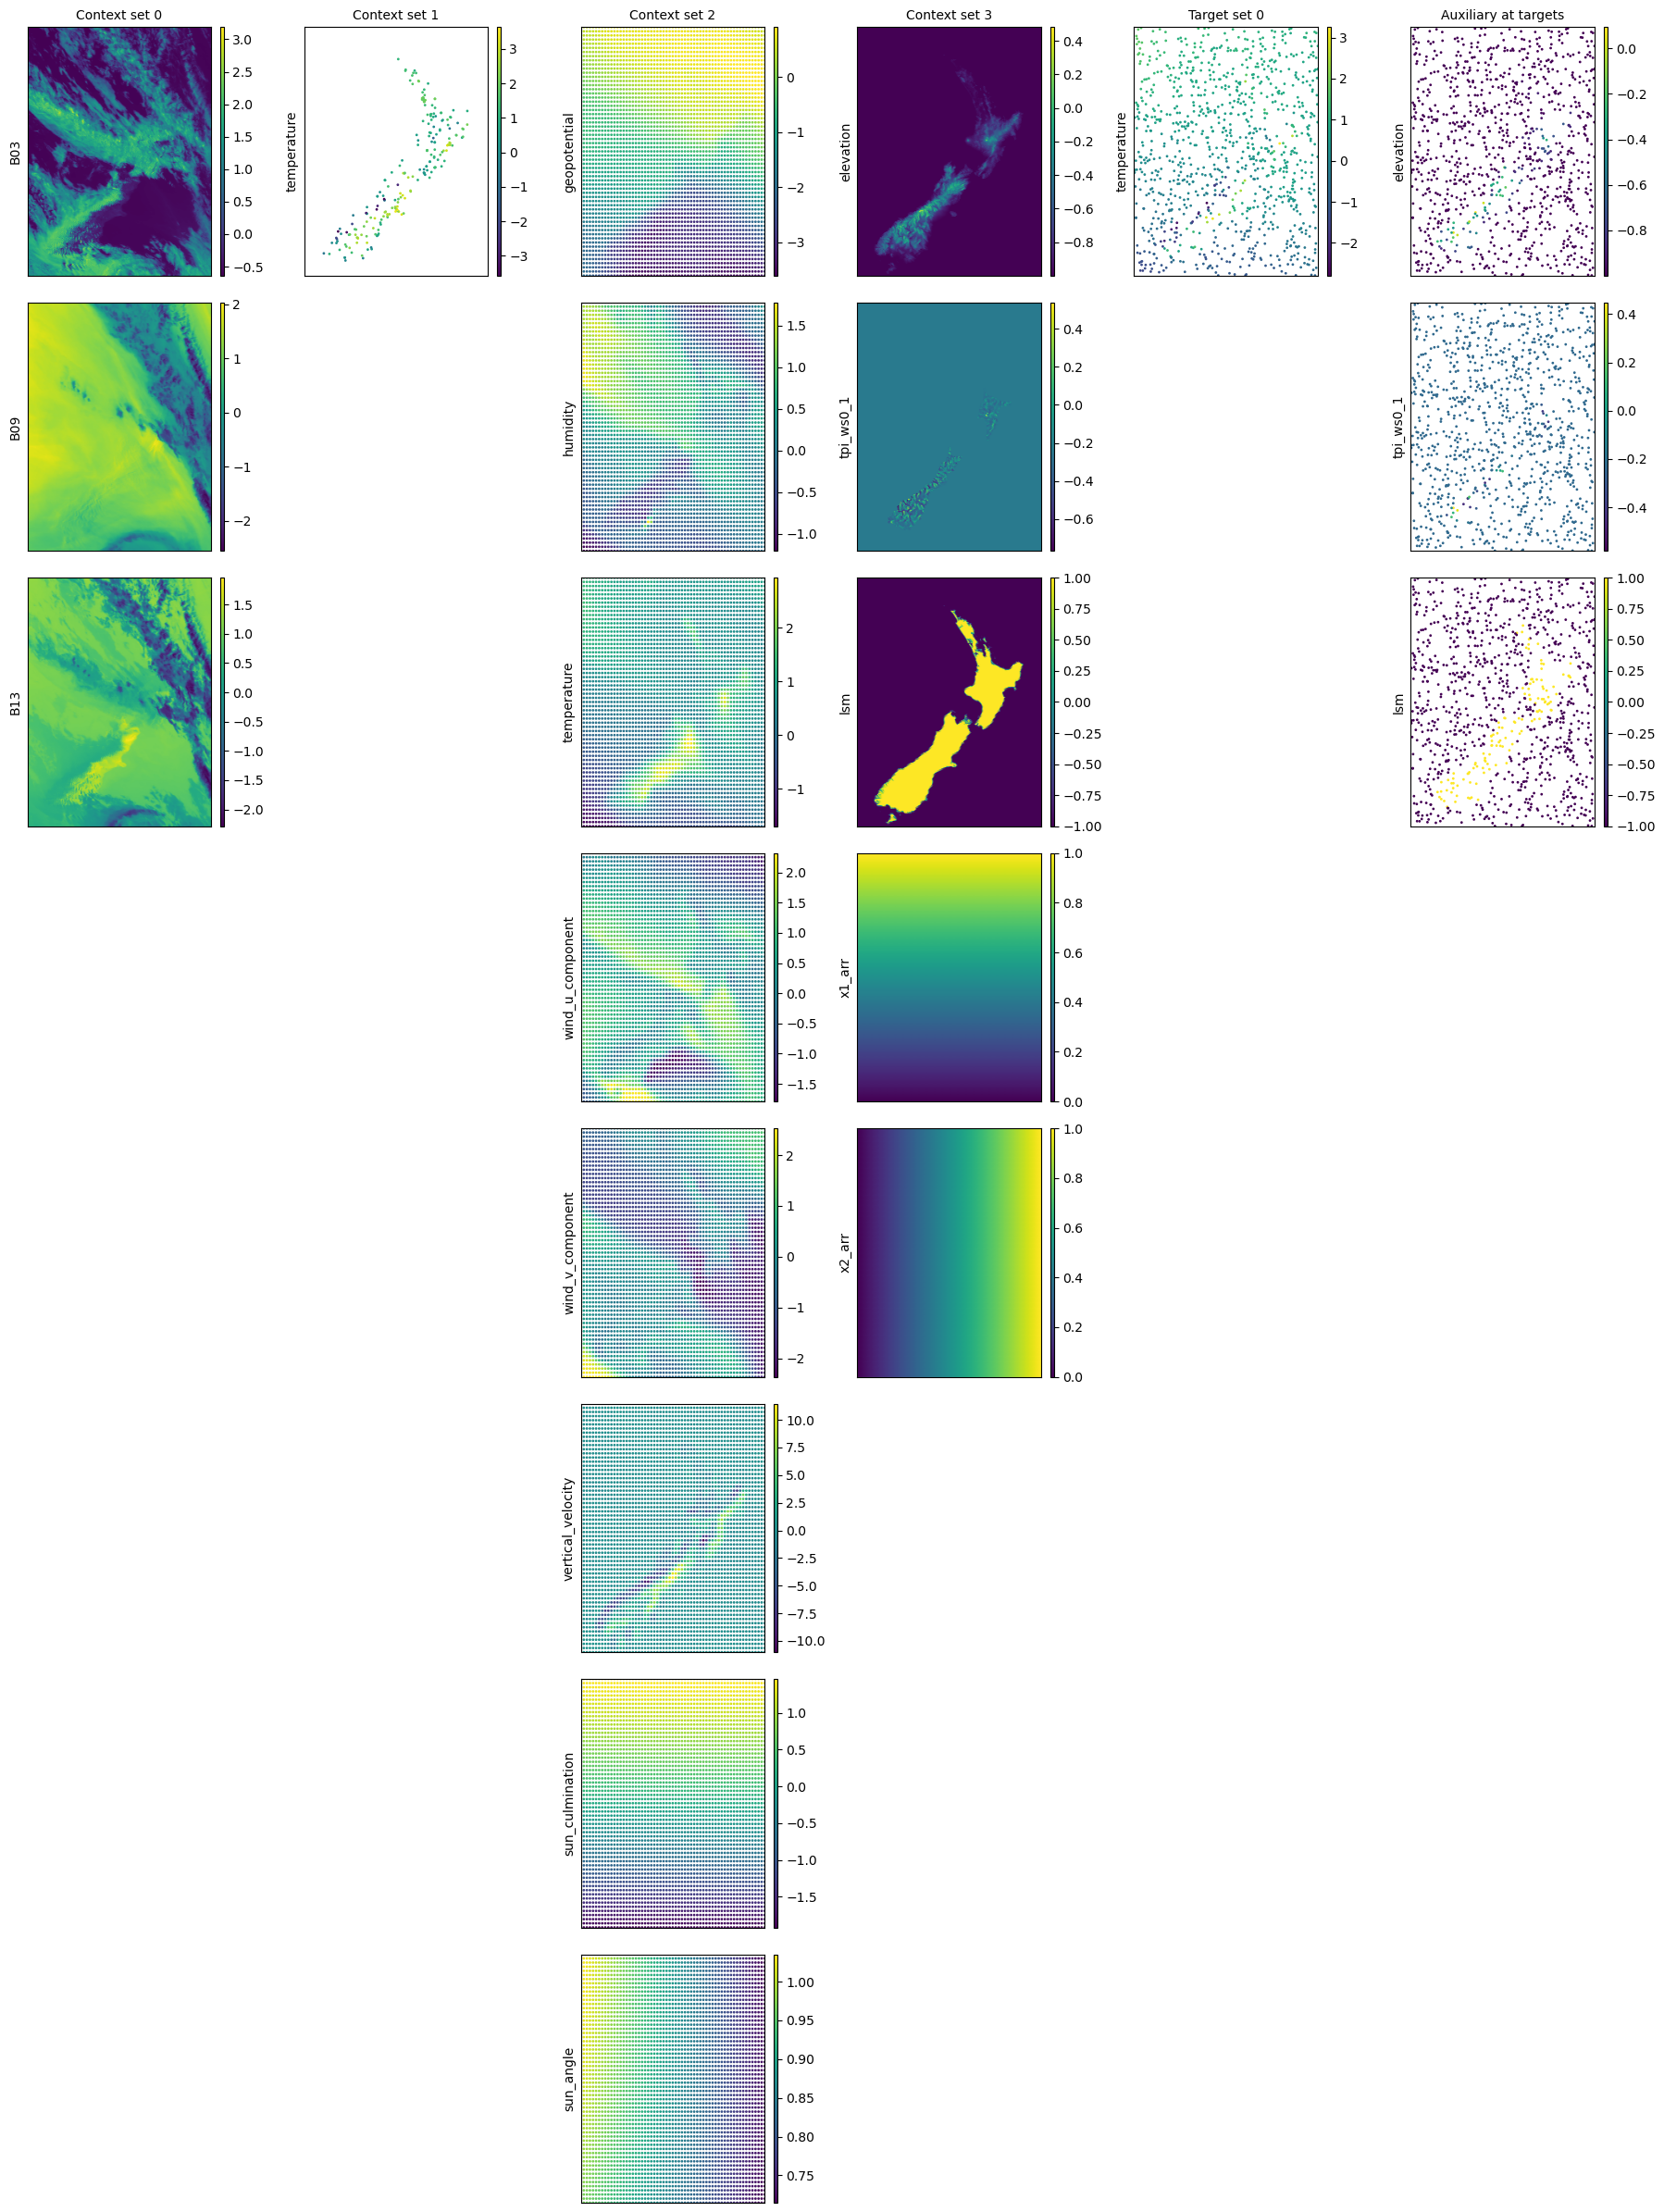

In [63]:
task_to_plot = task_loader(train_datetimes[0], context_sampling=["all", "all", "all", "all"], target_sampling=[target_sampling_count])

plot_task = deepsensor.plot.task(task_to_plot, task_loader)
plot_task.show()

In [ ]:
# save demo task to tensorboard
tb_writer.add_figure(TB_EXAMPLE_TASK, plot_task.figure)
tb_writer.flush()

## Model Training

In [33]:
import torch
from torch.optim import Adam
from convcnp_assim_nz.learning.model_training import train_epoch_pickled, compute_val_loss_pickled

In [41]:
n_epochs = 2
lr = 5e-5
batch_size = 16

In [ ]:
tb_writer.add_hparams(
    {
        'initial_learning_rate': lr,
        'batch_size': batch_size,
        'target_sampling_count': target_sampling_count,
        'repeat_sampling': repeat_sampling,
        'dev_mode': dev
    },
    {}
)

tb_writer.add_text(TB_RUN_LOGS, f"Training started for {n_epochs} epochs.", 3)
tb_writer.flush()

In [35]:
logger.info("Model training starting.")

2026-01-11 23:12:29 - INFO - __main__ - Model training starting.


In [ ]:
# training loop. Train baseline model for 50 epochs.
opt = Adam(model.model.parameters(), lr=lr)

for epoch in range(n_epochs):
    batch_losses = train_epoch_pickled(model, train_dir, opt, batch_size=batch_size)
    
    train_loss = np.mean(batch_losses)

    tb_writer.add_scalar(TB_TRAIN_LOSS, train_loss, epoch+1)
    tb_writer.add_scalar(TB_CUDA_MEM, torch.cuda.max_memory_reserved()/1024**2, epoch+1)
    tb_writer.flush()
    
    # you could add early stopping or model checkpointing here
    
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            val_loss = compute_val_loss_pickled(model, val_dir)
            tb_writer.add_scalar(TB_VAL_LOSS, val_loss, epoch+1)
            tb_writer.flush()

            logger.info(f"Epoch {epoch+1} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")
    

  0%|          | 0/11 [00:00<?, ?it/s]/esi/project/niwa00004/crowelenn/dev/convcnp-assim-nz/.pixi/envs/default/lib/python3.13/site-packages/lab/types.py:204: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


: 

: 

: 

In [ ]:
logger.info("Model training and notebook execution completed.")

In [ ]:
tb_writer.add_text(TB_RUN_LOGS, "Model training and notebook execution completed.", 4)
tb_writer.flush()